# DICOM VIEWER

This project aims to develop a 3D DICOM (Digital Imaging and Communications in Medicine) viewer using Python. The viewer enables medical professionals and researchers to visualize and interact with medical imaging data in three dimensions. By leveraging Python's powerful libraries, this tool processes DICOM files—the standard format for medical imaging—and renders them into interactive 3D visualizations. The viewer supports various medical imaging modalities, making it a versatile solution for healthcare professionals who need to analyze and interpret medical scans effectively.

The sample dataset used in this project is sourced from:
[Alize Medical Imaging](https://www.aliza-dicom-viewer.com/download/datasets).


In [1]:
""" Import Library """

# Data processing and scientific computing
import numpy as np

# Medical image processing
import pydicom

# Visualization
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from skimage import measure

# File handling and system operations
import glob
import os
import py7zr

# 3D mesh processing
import trimesh
import pyvista as pv


In [2]:
""" Read DICOM file in current directory """

files_7z = glob.glob('*.7z')
print("Found .7z files:")
p7zip_files = []
for file in files_7z:
    print(f"- {file} ({os.path.getsize(file)/1024:.2f} KB)")
    p7zip_files.append(file)

Found .7z files:
- Siemens_ep2d_diff.7z (6469.68 KB)


In [3]:
""" Extract DICOM files from .7z archive """

extract_to = 'dicom_files'
if not os.path.exists(extract_to):
    os.makedirs(extract_to)

for file in p7zip_files:
    with py7zr.SevenZipFile(file, mode='r') as z:
        z.extractall(path=extract_to)
        print(f"Extracted {file} to {extract_to}")

Extracted Siemens_ep2d_diff.7z to dicom_files


In [4]:
""" Load DICOM files and sort them by InstanceNumber """

def load_dicom_series(folder):
    # Find all DICOM files recursively in all subfolders
    files = []
    for root, _, filenames in os.walk(folder):
        for filename in filenames:
            if filename.endswith('.dcm'):
                files.append(os.path.join(root, filename))
    
    datasets = [pydicom.dcmread(f) for f in files]
    datasets.sort(key=lambda s: float(s.ImagePositionPatient[2]))
    
    pixel_arrays = [s.pixel_array for s in datasets]
    volume = np.stack(pixel_arrays, axis=-1)
    return volume


volume = load_dicom_series(extract_to)

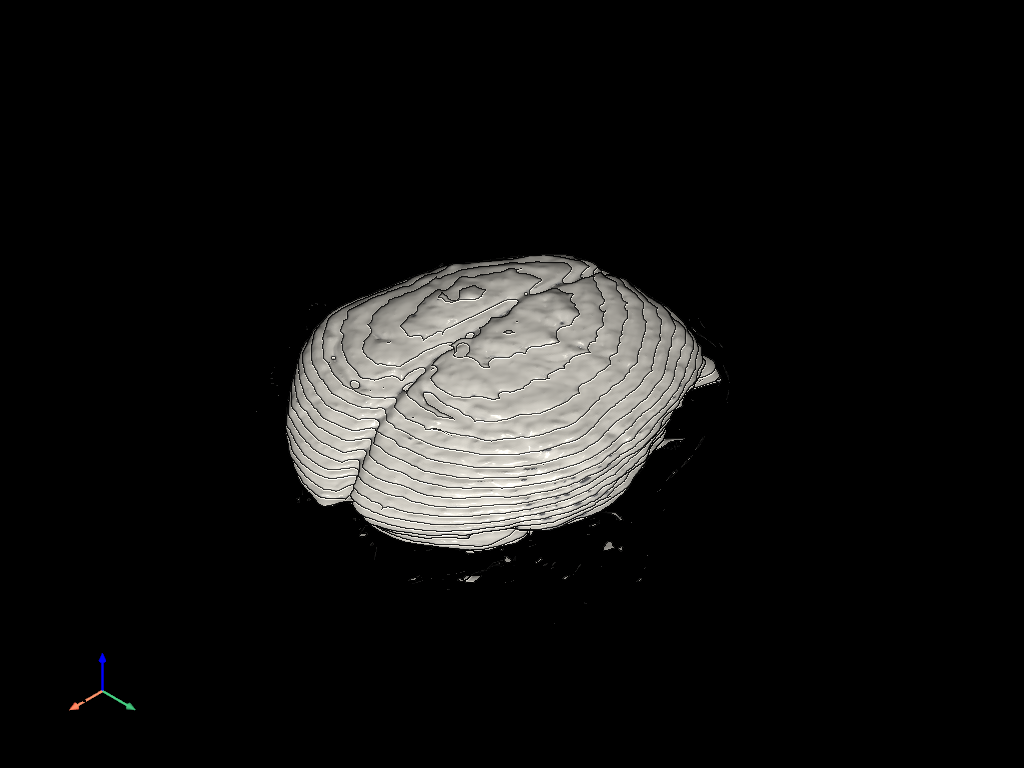

In [5]:
""" Extract and Visualize 3D Mesh """

def create_3d_model_from_volume(volume, threshold_percentile=95, smooth=True):
    # Normalize volume
    volume_normalized = volume.astype(float)
    threshold = np.percentile(volume_normalized, threshold_percentile)
    
    # Create grid with correct dimensions
    grid = pv.ImageData()
    grid.dimensions = volume.shape  # Remove the +1 to match array size
    grid.origin = (0, 0, 0)
    grid.spacing = (1, 1, 1)
    
    # Ensure data is properly shaped
    volume_flat = volume_normalized.flatten(order='F')
    grid.point_data["values"] = volume_flat
    
    # Generate contours with better quality
    contours = grid.contour(isosurfaces=[threshold], compute_normals=True, compute_gradients=True)
    
    # Optional smoothing
    if smooth:
        contours = contours.smooth(n_iter=100, relaxation_factor=0.1)
    
    return contours

# Create mesh with customizable parameters
mesh = create_3d_model_from_volume(volume, threshold_percentile=90, smooth=True)

# Configure PyVista to use static notebook plotting
pv.set_jupyter_backend('static')

# Enhanced visualization
plotter = pv.Plotter(notebook=True)
plotter.add_mesh(mesh, 
                 color='white',
                 specular=0.5,
                 ambient=0.3,
                 smooth_shading=True,
                 show_edges=False)
plotter.add_axes()
plotter.set_background('black')
plotter.camera_position = 'iso'
plotter.enable_eye_dome_lighting()

# Capture and display the image
plotter.show(jupyter_backend='static')